In [1]:
import os
import pandas as pd
import uproot
import numpy as np
import pickle
import vector
from sklearn.metrics import roc_curve, auc
import scipy
import HH4b.utils as utils

Import libraries

In [34]:
import hist
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

hep.style.use(["CMS", "firamath"])

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"

bdt_axis = hist.axis.Regular(40, 0, 1, name="bdt", label=r"BDT")
xbb_axis = hist.axis.Regular(40, 0.7, 1, name="xbb", label=r"Xbb")
msd_axis = hist.axis.Regular(40, 0, 250, name="msd", label=r"m$_{SD}$ GeV")
mreg_axis = hist.axis.Regular(40, 0, 250, name="mreg", label=r"m$_{reg}$ GeV")

cat_axis = hist.axis.StrCategory([], name="cat", growth=True)

In [3]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [48]:
MAIN_DIR = "../../../"
year = "2022EE"
samples = {
    "hh4b": [
        "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV",
    ],
    "qcd": [
        "QCD_HT-1000to1200",
        "QCD_HT-100to200",
        "QCD_HT-1200to1500",
        "QCD_HT-1500to2000",
        "QCD_HT-2000",
        "QCD_HT-200to400",
        "QCD_HT-400to600",
        "QCD_HT-600to800",
        "QCD_HT-800to1000",
    ],
    "ttbar": [
        "TTto2L2Nu",
        "TTto4Q",
        "TTtoLNu2Q",
    ],
}

dirs = {f"{MAIN_DIR}/../data/skimmer/24Mar2_v12_signal": samples}

# columns to load
load_columns = [
    ("weight", 1),
    ("MET_pt", 1),
    ("nFatJets", 1),
    ("bbFatJetPt", 2),
    ("bbFatJetEta", 2),
    ("bbFatJetPhi", 2),
    ("bbFatJetMsd", 2),
    ("bbFatJetPNetMass", 2),
    ("bbFatJetPNetXbb", 2),
    ("bbFatJetTau3OverTau2", 2),
    ("bbFatJetPNetQCD0HF", 2),
    ("bbFatJetPNetQCD1HF", 2),
    ("bbFatJetPNetQCD2HF", 2),
]
# reformat into ("column name", "idx") format for reading multiindex columns
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")

filters = [
    [
        ("('bbFatJetPt', '0')", ">=", 250),
        ("('bbFatJetPt', '1')", ">=", 250),
    ],
]

events_dict = {}
for input_dir, samples in dirs.items():
    print(samples)
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(input_dir, samples, year, filters=filters, columns_mc=columns),
    }

{'hh4b': ['GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV'], 'qcd': ['QCD_HT-1000to1200', 'QCD_HT-100to200', 'QCD_HT-1200to1500', 'QCD_HT-1500to2000', 'QCD_HT-2000', 'QCD_HT-200to400', 'QCD_HT-400to600', 'QCD_HT-600to800', 'QCD_HT-800to1000'], 'ttbar': ['TTto2L2Nu', 'TTto4Q', 'TTtoLNu2Q']}
Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV
Loading QCD_HT-2000
Loading QCD_HT-400to600
Loading QCD_HT-800to1000
Loading QCD_HT-600to800
Loading QCD_HT-1500to2000
Loading QCD_HT-200to400
Loading QCD_HT-1000to1200
Loading QCD_HT-1200to1500
Loading QCD_HT-100to200
Loading TTto2L2Nu
Loading TTtoLNu2Q
Loading TTto4Q


Check BDT peformance

In [5]:
# load model
from xgboost import XGBClassifier

model = XGBClassifier()
model.load_model(fname=f"{MAIN_DIR}/../data/bdt_trainings_run3/boostedBDT_test.json")

/Users/cmantill/miniconda3/envs/coffea/lib/python3.8/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Make BDT dataframe

In [47]:
def bdt_dataframe(key):
    events = events_dict[key]

    h1 = vector.array(
        {
            "pt": events["bbFatJetPt"].to_numpy()[:, 0],
            "phi": events["bbFatJetPhi"].to_numpy()[:, 0],
            "eta": events["bbFatJetEta"].to_numpy()[:, 0],
            "M": events["bbFatJetMsd"].to_numpy()[:, 0],
        }
    )
    h2 = vector.array(
        {
            "pt": events["bbFatJetPt"].to_numpy()[:, 1],
            "phi": events["bbFatJetPhi"].to_numpy()[:, 1],
            "eta": events["bbFatJetEta"].to_numpy()[:, 1],
            "M": events["bbFatJetMsd"].to_numpy()[:, 1],
        }
    )
    hh = h1 + h2

    # bdt variables
    df = pd.DataFrame(
        {
            # dihiggs system
            "HHlogPt": np.log(hh.pt),
            "HHeta": hh.eta,
            "HHmass": hh.mass,
            # met in the event
            "MET": events.MET_pt[0],
            # fatjet tau32
            "H1T32": events["bbFatJetTau3OverTau2"].to_numpy()[:, 0],
            "H2T32": events["bbFatJetTau3OverTau2"].to_numpy()[:, 1],
            # fatjet mass
            "H1Msd": events["bbFatJetMsd"].to_numpy()[:, 0],
            "H2Msd": events["bbFatJetMsd"].to_numpy()[:, 1],
            # fatjet kinematics
            "H1Pt": h1.pt,
            "H2Pt": h2.pt,
            "H1logPt": np.log(h1.pt),
            "H2logPt": np.log(h2.pt),
            "H1eta": h1.eta,
            "H2eta": h2.eta,
            "H1_dRH2": h1.deltaR(h2),
            "H1_dPhiH2": h1.deltaphi(h2),
            # xbb
            "H1Xbb": events["bbFatJetPNetXbb"].to_numpy()[:, 0],
            "H1QCD1HF": events["bbFatJetPNetQCD1HF"].to_numpy()[:, 0],
            "H1QCD2HF": events["bbFatJetPNetQCD2HF"].to_numpy()[:, 0],
            "H1QCD0HF": events["bbFatJetPNetQCD0HF"].to_numpy()[:, 0],
            # ratios
            "H1Pt_HHmass": h1.pt / hh.mass,
            "H2Pt_HHmass": h2.pt / hh.mass,
            "H1Pt/H2Pt": h1.pt / h2.pt,
            # PNet mass
            "H1PNetMass": events["bbFatJetPNetMass"].to_numpy()[:, 0],
            "H2PNetMass": events["bbFatJetPNetMass"].to_numpy()[:, 1],
            # H2
            "H2Xbb": events["bbFatJetPNetXbb"].to_numpy()[:, 1],
            # weight
            "weight": events["weight"].to_numpy()[:, 0],
        }
    )
    df.replace(np.inf, 10000, inplace=True)
    df.replace(-np.inf, 10000, inplace=True)

    return df


variables_not_in_bdt = [
    # not use PnetMass until we debug it
    "H1PNetMass",
    # not use H2 mass to avoid correlations
    "H2Msd",
    "H2PNetMass",
    # not use H2Xbb so that we can further cut on it
    "H2Xbb",
    # these sculpt the mass
    "H1_dRH2",
    "H1_dPhiH2",
    # weight
    "weight",
    # pts
    "H1Pt",
    "H2Pt",
]

In [15]:
events_dict_bdt = {}
weights_bdt = {}
for key in ["hh4b", "qcd", "ttbar"]:
    events_dict_bdt[key] = bdt_dataframe(key)
    weights_bdt[key] = np.abs(events_dict[key]["weight"].to_numpy()[:, 0])
    df = events_dict_bdt[key].drop(columns=variables_not_in_bdt)
    events_dict_bdt[key]["bdt_prediction"] = model.predict_proba(df)[:, 1]

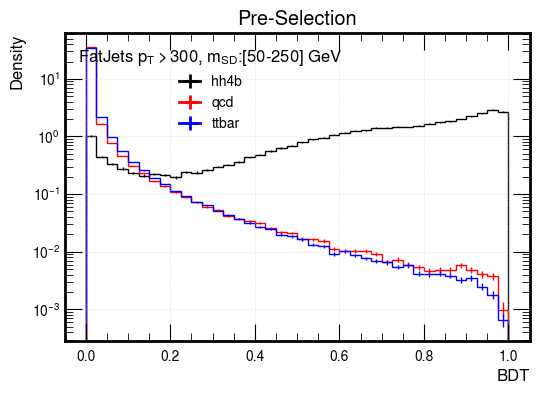

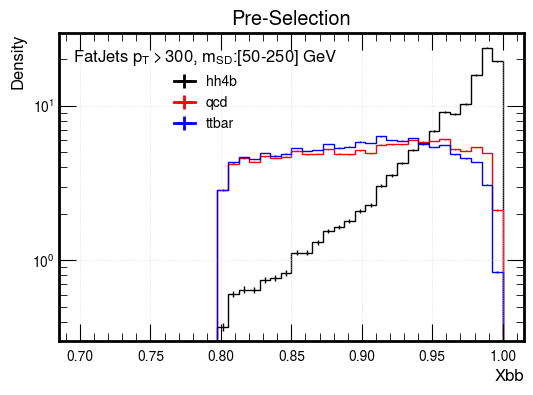

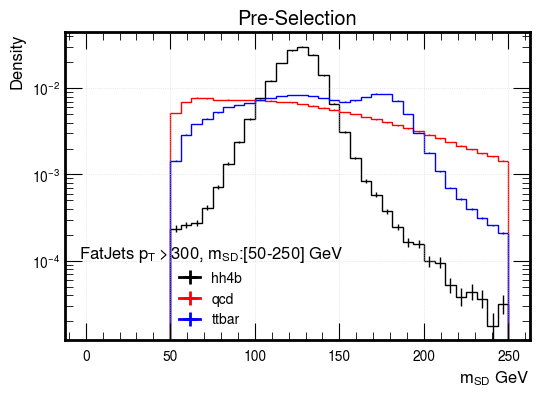

In [35]:
h_bdt = hist.Hist(bdt_axis, cat_axis)
h_xbb0 = hist.Hist(xbb_axis, cat_axis)
h_msd1 = hist.Hist(msd_axis, cat_axis)

scores = {}
weights = {}
txbb1 = {}
for key in ["hh4b", "qcd", "ttbar"]:
    events = events_dict_bdt[key]
    mask = (events["H1Msd"] > 50) & (
        events["H2Msd"] > 50
    )  # & (events["H1Msd"] < 250) & (events["H2Msd"] < 250)

    h_bdt.fill(bdt=events[mask]["bdt_prediction"].to_numpy(), cat=key)
    h_xbb0.fill(xbb=events[mask]["H1Xbb"].to_numpy(), cat=key)
    h_msd1.fill(msd=events[mask]["H1Msd"].to_numpy(), cat=key)

    scores[key] = events[mask]["bdt_prediction"].to_numpy()
    weights[key] = events[mask]["weight"].to_numpy()
    txbb1[key] = events[mask]["H2Xbb"]

colors = {"ttbar": "b", "hh4b": "k", "qcd": "r"}

hists = {
    "bdt": h_bdt,
    "xbb_0": h_xbb0,
    "msd_1": h_msd1,
    # "mreg_1": h_mreg1,
}

for hname, hhist in hists.items():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for key in ["hh4b", "qcd", "ttbar"]:
        hep.histplot(
            hhist[{"cat": key}],
            ax=ax,
            label=f"{key}",
            histtype="step",
            linewidth=1,
            color=colors[key],
            density=True,
        )

    ax.set_yscale("log")
    ax.legend(title=r"FatJets $p_T>$300, m$_{SD}$:[50-250] GeV")
    ax.set_ylabel("Density")
    ax.set_title("Pre-Selection")
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True, which="major")
    # plt.close()

qcd 0.9792306769305872
ttbar 0.9870103225959153
merged 0.9798863473937842
273454 0.03 0.9704058085730944 0.19213641107178045
148583 0.11 0.943688884883345 0.08012094981036222
86459 0.43 0.850422883387101 0.013537609089159335
{0.03: [[0.9704058085730944], [0.19213641107178045]], 0.11: [[0.943688884883345], [0.08012094981036222]], 0.43: [[0.850422883387101], [0.013537609089159335]]}


Text(0.2, 5e-05, 'QCD+TT')

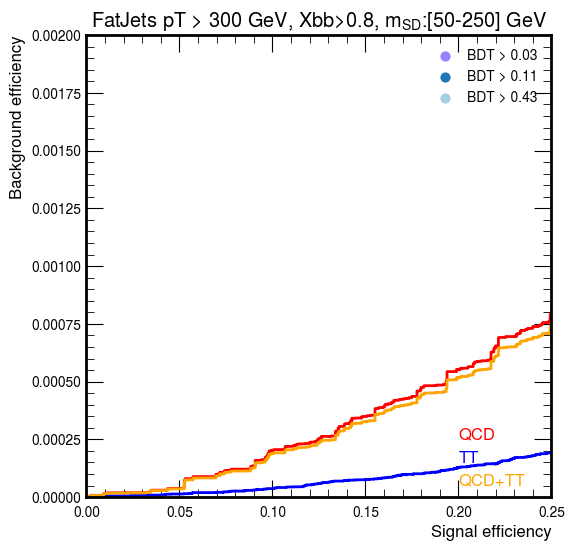

In [37]:
# make roc curve
fpr_dict = {}
auc_dict = {}
tpr_dict = {}
thresholds_dict = {}

for bkg in ["qcd", "ttbar", "merged"]:
    sig_jets_score = scores["hh4b"]
    if bkg == "merged":
        bkg_jets_score = np.concatenate((scores["qcd"], scores["ttbar"]))
        scores_weights = np.concatenate([weights["hh4b"], weights["qcd"], weights["ttbar"]])
    else:
        bkg_jets_score = scores[bkg]
        scores_weights = np.concatenate([weights["hh4b"], weights[bkg]])

    scores_roc = np.concatenate((sig_jets_score, bkg_jets_score))
    scores_true = np.concatenate(
        [
            np.ones(len(sig_jets_score)),
            np.zeros(len(bkg_jets_score)),
        ]
    )
    fpr, tpr, thresholds = roc_curve(scores_true, scores_roc, sample_weight=scores_weights)

    sorted_index = np.argsort(fpr)
    fpr_sorted = np.array(fpr)[sorted_index]
    tpr_sorted = np.array(tpr)[sorted_index]
    auc_dict[bkg] = scipy.integrate.trapz(y=tpr_sorted, x=fpr_sorted)
    fpr_dict[bkg] = fpr
    tpr_dict[bkg] = tpr
    thresholds_dict[bkg] = thresholds


plt.figure(figsize=(6, 6))
bkg_colors = {
    "qcd": "r",
    "ttbar": "blue",
    "merged": "orange",
}

for bkg in ["qcd", "ttbar", "merged"]:
    print(bkg, auc_dict[bkg])

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

    plot_thresholds = [0.03, 0.11, 0.43]
    th_colours = ["#9381FF", "#1f78b4", "#a6cee3"]

    plt.plot(tpr_dict[bkg], fpr_dict[bkg], linewidth=2, color=bkg_colors[bkg])

    if bkg == "merged":
        pths = {th: [[], []] for th in plot_thresholds}

        for th in plot_thresholds:
            idx = find_nearest(thresholds_dict[bkg], th)
            print(idx, th, tpr_dict[bkg][idx], fpr_dict[bkg][idx])
            pths[th][0].append(tpr_dict[bkg][idx])
            pths[th][1].append(fpr_dict[bkg][idx])

        print(pths)

        for k, th in enumerate(plot_thresholds):
            plt.scatter(
                *pths[th],
                marker="o",
                s=40,
                label=rf"BDT > {th}",
                color=th_colours[k],
                zorder=100,
            )

            plt.vlines(
                x=pths[th][0],
                ymin=0,
                ymax=pths[th][1],
                color=th_colours[k],
                linestyles="dashed",
                alpha=0.5,
            )

            plt.hlines(
                y=pths[th][1],
                xmin=0,
                xmax=pths[th][0],
                color=th_colours[k],
                linestyles="dashed",
                alpha=0.5,
            )

plt.title(r"FatJets pT > 300 GeV, Xbb>0.8, m$_{SD}$:[50-250] GeV")
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
plt.xlim([0.0, 0.25])
plt.ylim([0, 0.002])
plt.legend()
plt.text(0.2, 0.00025, "QCD", color=bkg_colors["qcd"])
plt.text(0.2, 0.00015, "TT", color=bkg_colors["ttbar"])
plt.text(0.2, 0.00005, "QCD+TT", color=bkg_colors["merged"])

qcd 0.5265122338450868
ttbar 0.5264693190179796
merged 0.5265086198148112


Text(0.2, 5e-05, 'QCD+TT')

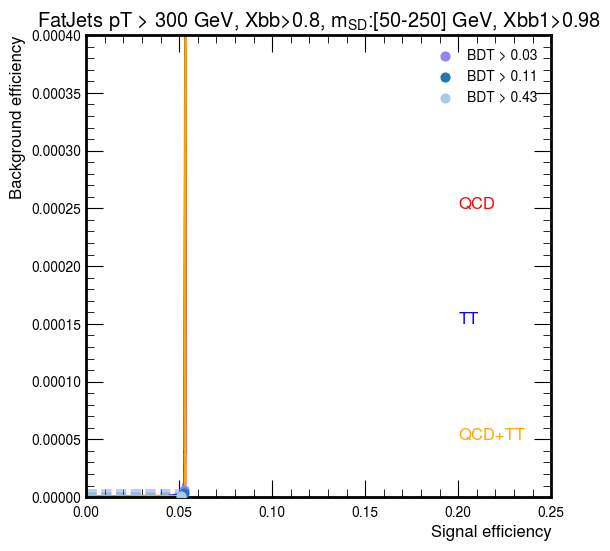

In [33]:
fpr_dict = {}
tpr_dict = {}
thresholds_dict = {}

plt.figure(figsize=(6, 6))
for bkg in ["qcd", "ttbar", "merged"]:
    sig_jets_score = scores["hh4b"]
    if bkg == "merged":
        bkg_jets_score = np.concatenate((scores["qcd"], scores["ttbar"]))
        scores_weights = np.concatenate([weights["hh4b"], weights["qcd"], weights["ttbar"]])
        scores_txbb = pd.concat([txbb1["hh4b"], txbb1["qcd"], txbb1["ttbar"]], axis=0)
    else:
        bkg_jets_score = scores[bkg]
        scores_weights = np.concatenate([weights["hh4b"], weights[bkg]])
        scores_txbb = pd.concat([txbb1["hh4b"], txbb1[bkg]], axis=0)

    scores_roc = np.concatenate((sig_jets_score, bkg_jets_score))
    scores_true = np.concatenate(
        [
            np.ones(len(sig_jets_score)),
            np.zeros(len(bkg_jets_score)),
        ]
    )
    scores_roc_thresholded = scores_roc.copy()
    scores_roc_thresholded[scores_txbb < 0.98] = 0

    fpr, tpr, thresholds = roc_curve(
        scores_true, scores_roc_thresholded, sample_weight=scores_weights
    )
    fpr_dict[bkg] = fpr
    tpr_dict[bkg] = tpr
    thresholds_dict[bkg] = thresholds
    sorted_index = np.argsort(fpr)
    fpr_sorted = np.array(fpr)[sorted_index]
    tpr_sorted = np.array(tpr)[sorted_index]
    auc_dict[bkg] = scipy.integrate.trapz(y=tpr_sorted, x=fpr_sorted)

for bkg in ["qcd", "ttbar", "merged"]:
    print(bkg, auc_dict[bkg])

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

    plot_thresholds = [0.03, 0.11, 0.43]
    th_colours = ["#9381FF", "#1f78b4", "#a6cee3"]

    pths = {th: [[], []] for th in plot_thresholds}

    plt.plot(tpr_dict[bkg], fpr_dict[bkg], linewidth=2, color=bkg_colors[bkg])

    if bkg != "merged":
        continue

    for th in plot_thresholds:
        idx = find_nearest(thresholds_dict[bkg], th)
        pths[th][0].append(tpr_dict[bkg][idx])
        pths[th][1].append(fpr_dict[bkg][idx])

    for k, th in enumerate(plot_thresholds):
        plt.scatter(
            *pths[th],
            marker="o",
            s=40,
            label=rf"BDT > {th}",
            color=th_colours[k],
            zorder=100,
        )

        plt.vlines(
            x=pths[th][0],
            ymin=0,
            ymax=pths[th][1],
            color=th_colours[k],
            linestyles="dashed",
            alpha=0.5,
        )

        plt.hlines(
            y=pths[th][1],
            xmin=0,
            xmax=pths[th][0],
            color=th_colours[k],
            linestyles="dashed",
            alpha=0.5,
        )

plt.title(r"FatJets pT > 300 GeV, Xbb>0.8, m$_{SD}$:[50-250] GeV, Xbb1>0.98")
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
plt.xlim([0.0, 0.25])
plt.ylim([0, 0.0004])
plt.legend()
plt.text(0.2, 0.00025, "QCD", color=bkg_colors["qcd"])
plt.text(0.2, 0.00015, "TT", color=bkg_colors["ttbar"])
plt.text(0.2, 0.00005, "QCD+TT", color=bkg_colors["merged"])

In [32]:
yields = {}
yields_bdt043 = {}
yields_bdt043_xbb098 = {}


for key in ["hh4b", "qcd", "ttbar"]:
    events = events_dict_bdt[key]

    # bdt043
    mask = events["bdt_prediction"] > 0.93

    # xbb 098
    mask_xbb = mask & (events["H2Xbb"] > 0.98)

    lumi = 13700

    yields[key] = np.sum(lumi * events["weight"])
    yields_bdt043[key] = np.sum(lumi * events[mask]["weight"])
    yields_bdt043_xbb098[key] = np.sum(lumi * events[mask_xbb]["weight"])

sig_eff_bdt043 = yields_bdt043["hh4b"] / yields["hh4b"]
bkg_eff_bdt043 = (yields_bdt043["qcd"] + yields_bdt043["ttbar"]) / (yields["qcd"] + yields["ttbar"])

sig_eff_bdt043_xbb098 = yields_bdt043_xbb098["hh4b"] / yields["hh4b"]
bkg_eff_bdt043_xbb098 = (yields_bdt043_xbb098["qcd"] + yields_bdt043_xbb098["ttbar"]) / (
    yields["qcd"] + yields["ttbar"]
)

print(yields)
print(
    yields_bdt043,
    sig_eff_bdt043,
    bkg_eff_bdt043,
    2 * yields_bdt043["hh4b"] / np.sqrt(yields_bdt043["qcd"] + yields_bdt043["ttbar"]),
)
print(
    yields_bdt043_xbb098,
    sig_eff_bdt043_xbb098,
    bkg_eff_bdt043_xbb098,
    2
    * yields_bdt043_xbb098["hh4b"]
    / np.sqrt(yields_bdt043_xbb098["qcd"] + yields_bdt043_xbb098["ttbar"]),
)

{'hh4b': 65383.78129475029, 'qcd': 12211887975.68886, 'ttbar': 482541429.9493985}
{'hh4b': 10256.25746620566, 'qcd': 7071843.524031718, 'ttbar': 56240.83691606459} 0.15686240934843487 0.0005615127811717027 7.683029394236455
{'hh4b': 1310.0793319469958, 'qcd': 2365.660878858491, 'ttbar': 344.9535041233063} 0.020036763032121898 2.1352786299933038e-07 50.32615161276526


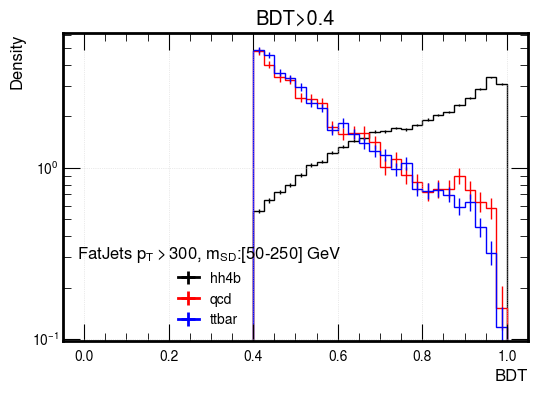

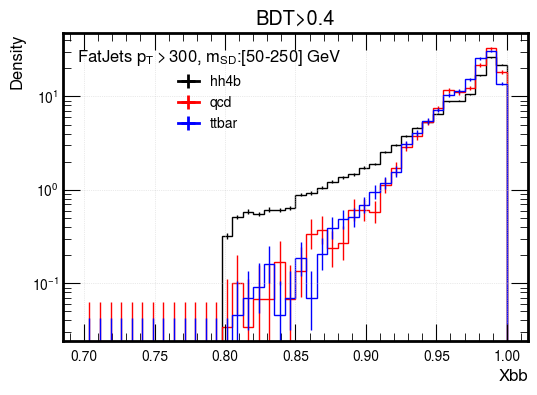

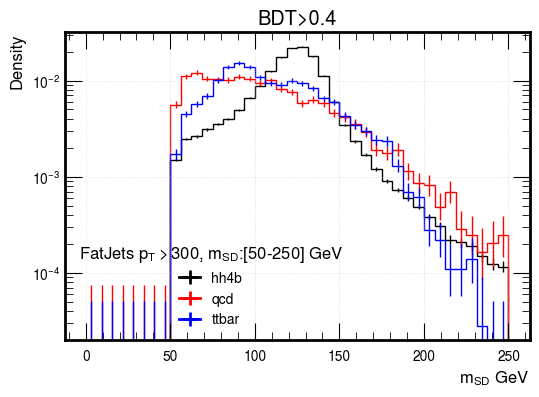

In [46]:
h_bdt = hist.Hist(bdt_axis, cat_axis)
h_xbb0 = hist.Hist(xbb_axis, cat_axis)
h_msd1 = hist.Hist(msd_axis, cat_axis)

scores = {}
weights = {}
txbb1 = {}
for key in ["hh4b", "qcd", "ttbar"]:
    events = events_dict_bdt[key]
    mask = (
        (events["H1Msd"] > 50)
        & (events["H2Msd"] > 50)
        & (events["H1Msd"] < 250)
        & (events["H2Msd"] < 250)
        & (events["bdt_prediction"] > 0.4)
    )

    h_bdt.fill(bdt=events[mask]["bdt_prediction"].to_numpy(), cat=key)
    h_xbb0.fill(xbb=events[mask]["H1Xbb"].to_numpy(), cat=key)
    h_msd1.fill(msd=events[mask]["H2Msd"].to_numpy(), cat=key)

    scores[key] = events[mask]["bdt_prediction"].to_numpy()
    weights[key] = events[mask]["weight"].to_numpy()
    txbb1[key] = events[mask]["H2Xbb"]

colors = {"ttbar": "b", "hh4b": "k", "qcd": "r"}

hists = {
    "bdt": h_bdt,
    "xbb_0": h_xbb0,
    "msd_1": h_msd1,
    # "mreg_1": h_mreg1,
}

for hname, hhist in hists.items():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for key in ["hh4b", "qcd", "ttbar"]:
        hep.histplot(
            hhist[{"cat": key}],
            ax=ax,
            label=f"{key}",
            histtype="step",
            linewidth=1,
            color=colors[key],
            density=True,
        )

    ax.set_yscale("log")
    ax.legend(title=r"FatJets $p_T>$300, m$_{SD}$:[50-250] GeV")
    ax.set_ylabel("Density")
    ax.set_title("BDT>0.4")
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True, which="major")